In [1]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")
from mfilter.implementations.simulate import SimulateSignal
from mfilter.regressions import *
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.filter import *
from microlensing import *

%matplotlib inline
plt.style.use('seaborn')

# Signal detection with matched filter


### Motivation
* LIGO works on gravitational waves
    * Perform a signal detection usign as impulse response a lot of templates.

### Basic Idea
* Introduce Matched filter and with the use of Fourier Transform, compute a fast optimiization of what would be the optimal Signal to Noise Ratio (SNR) of any input observation data with an impulse response filter

Where te linear filter is: 

$$ (x | h) = [x * h](t_0) = \int_{-\infty}^{\infty} \tilde{x}(f)\tilde{h}^{*}(f) e^{2 \pi i f t_0} df$$
    
### Steps
* Change from evenly sampled data to un-evenly sampled data and with this use NFFT or regression.
    * for the Direct Transform:
    $$ F^{-1}[\tilde{x}(f)] = x(t) = 2\int_{0}^{\infty} \tilde{x}(f)e^{2 \pi i f t} df \longrightarrow x_j = 2 \sum_{n = 0}^{N} \tilde{x}[k] e^{2\pi i \Delta f k t_n} $$
    * And the Adjoint Transform:
$$ F[x(t)] = \tilde{x}(f) = 2\int_{0}^{\infty} x(t) e^{-2\pi i f t} dt  \longrightarrow \tilde{x}_k = 2 \sum_{n = 0}^{N} x[n] e^{-2\pi i \Delta f k t_n}$$


* Then in un-evenly space compute:
    * Average PSD of the noise usign the data imput (Lomb-Welch periodogram) using Astropy Implementation
    * Estimate Inverse Fourier Transform using some iterative method. In this case is implemented for Linear Regressions and used mostly the Ridge Algorithm implemented in sklearn which minimize:
    
    $$ \underset{\omega}{\text{ min }} || X\omega - y ||^{2}_{2} + \alpha ||\omega||_{2}^{2}$$
    
    Where $\omega$ is the penalty introduced to avoid singular matrix.
    

score of the regresion of template 0.99861463350612
score of the regresion of template2 0.9984925143957611
score of the regresion of data 0.9981366983627332


TypeError: object of type 'NoneType' has no len()

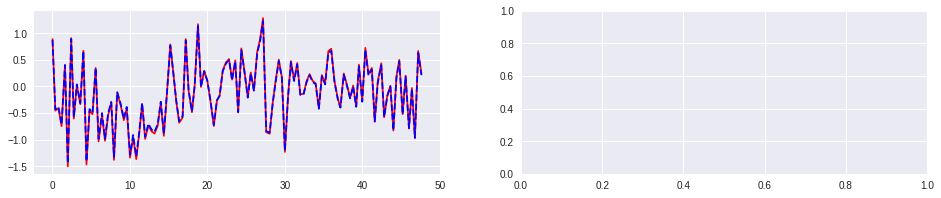

In [2]:
delta_t = 0.8 / 2
n = 60*2
struct = "slight"
times = TimesSamples(n=n, delta=delta_t, struct=struct)

def eval(U0, t0, tE, fs, times):
    """Evaluate microlens event at given time array, return magnitude difference
    Function taken from Microlensing implementation"""
    u = np.sqrt(U0**2 + ((times - t0)  /tE )**2)
    A = (u**2 + 2.) / (u * np.sqrt(u**2 + 3))
    dm = - 2.5 * np.log10(fs*(A - 1) + 1)
    return dm

t0 = min(times) + times.duration/2
tE = 0.8 
U0 = 3 #1.3 
fs = 24 #16.9
val = eval(U0, times[n//5], tE, fs, times)

np.random.seed(1)
noise_data = np.random.normal(0, 0.6, n)
data = val + noise_data

tE = 0.8 
U0 = 3 #1.3 
fs = 24 #16.9
val = eval(U0, t0, tE, fs, times)

tE = 1
U0 = 4.3
fs = 22
val2 = eval(U0, t0, tE, fs, times)

val = TimeSeries(val, times=times)
val2 = TimeSeries(val2, times=times)
data = TimeSeries(data, times=times)
noise = TimeSeries(np.random.normal(0, 0.6, n), times=times)

## Fourier Transform

# define freq. grid
nyq = 1 / (2 * delta_t)
samples_per_peak = 5
df = 1 / times.duration / samples_per_peak
freqs = FrequencySamples(input_time=times,
                        minimum_frequency=samples_per_peak * df,
                        maximum_frequency=nyq + samples_per_peak * df,
                        samples_per_peak=samples_per_peak)
F = Dictionary(times, freqs)
# reg = LassoRegression(alpha=10**(-3), phi=F)
reg = RidgeRegression(alpha=10**(1), phi=F)
htilde = val.to_frequencyseries(reg=reg)
print("score of the regresion of template", reg.score(val))
htilde2 = val2.to_frequencyseries(reg=reg)
print("score of the regresion of template2", reg.score(val2))
ntilde = noise.to_frequencyseries(reg=reg)
stilde = data.to_frequencyseries(reg=reg)
print("score of the regresion of data", reg.score(data))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3))
ax1.plot(times, data, 'r', label='data')
# ax1.plot(times, val, 'k', label="template")
# ax1.plot(times, val2, 'g', label="template2")
ax1.plot(times, reg.predict(reg.dict), 'b--', label="reconstructed data")
ax1.plot(times, stilde.to_timeseries(reg=reg).real, label="backward data")
ax1.set_title("TimeSeries samples", fontsize=18)
ax1.set_xlabel("Times (seg)", fontsize=18)
ax1.legend(fontsize=16)

ax2.plot(freqs, abs(stilde), 'r', label="data")
# ax2.plot(freqs, abs(htilde), 'k', label="template")
# ax2.plot(freqs, abs(htilde2), 'k', label="template2")
ax2.set_title("Frequency Series samples", fontsize=18)
ax2.set_xlabel("Frequency (Hz)", fontsize=18)
# ax2.legend(fontsize=16)

plt.figure(figsize=(6, 3))
plt.plot(times, val, 'k', label="template")
plt.plot(times, val2, 'g', label="template2")
plt.xlabel("Times (seg)", fontsize=18)
plt.legend(fontsize=16)

In [ ]:
psd = data.psd(freqs)
psd0 = noise.psd(freqs)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(freqs, psd, 'o--', label="PSD of data")
# ax1.plot(freqs, psd0, 'go--', label="PSD of template")
ax1.set_title("direct PSD with lomb-scarble",fontsize=18)
ax1.set_xlabel("Frequency (Hz)", fontsize=18)
ax1.legend(fontsize=18)

def average_psd(segment_duration, oversampling_rate, timeSeries, freqs):
    N = timeSeries.duration / segment_duration
    n_seg = (int(N) - 1) / (1-oversampling_rate)
#     print(n_seg)
    t = 0
    psd = FrequencySeries(np.zeros(len(freqs)), frequency_grid=freqs, epoch=timeSeries.epoch)
    counter = 0
    while t < timeSeries.duration - segment_duration:
        aux_timeseries = timeSeries.get_time_slice(t, t+segment_duration)
        window = signal.windows.hann(len(aux_timeseries))
        aux_timeseries *= window
        W = (window ** 2).sum() / len(window)
#         W = 1
        psd += (aux_timeseries.psd(freqs) / W)
        t += (1-oversampling_rate) * segment_duration
        counter += 1
#     print("counter is: ", counter)
    aux_timeseries = timeSeries.get_time_slice(timeSeries.duration - segment_duration, timeSeries.duration)
    window = signal.windows.hann(len(aux_timeseries))
    aux_timeseries *= window
    W = (window ** 2).sum() / len(window)
#     W = 1
    psd += (aux_timeseries.psd(freqs) / W)
    psd /= (counter+1)
    
    return psd

seg_dur = times.duration//1
psd = average_psd(seg_dur, 0.5, data, freqs)
psd_test = average_psd(seg_dur, 0.5, TimeSeries(noise_data, times=times), freqs)
# np.random.seed(1)
# noise_data = np.random.normal(0, 0.2, n)
psd0 = average_psd(seg_dur, 0.5, noise, freqs)


ax2.plot(freqs, psd, label="estimated PSD of noise")
ax2.plot(freqs, psd_test, label="true PSD of noise")
# ax2.plot(freqs, psd0, 'g', label="PSD of template")
ax2.set_title("Average Lomg-Scargle PSD", fontsize=18)
ax2.set_xlabel("Frequency (Hz)", fontsize=18)
ax2.legend()


* Generalize Matched Filter for colored noise instead of Withe Noise using Whitening Filter, this still need a Wide Sense Stationary noise.

$$ S_n(f) |\tilde{h}_w(f)|^{2} = S_{w}(f) \text{ such that } \sigma^{2} = \int_{-\infty}^{\infty} S_w(f) df$$

where $S_n$ is the PSD of the noise data, $\tilde{h}_w$ is the Fourier Transform of the whitening filter and $S_w$ is the PSD of the Whitening filter. This directly leads to:

$$ |\tilde{h}_w(f)|^{2} =\frac{S_w(f)}{S_n(f)} = \frac{N_0}{S_n(f)}$$

this produce a Whitened Matched Filter:

$$ (x|h) = N_0 \int_{-\infty}^{\infty} \frac{\tilde{x}(f)\tilde{h}^{*}(f)}{S_n(f)} e^{2 \pi i f t_0} df $$

* Normalize SNR using Variance of the convolved output

$$ \sigma_h^{2} = N_0^{2}\int_{-\infty}^{\infty} \frac{|\tilde{h}^{*}(f)|^{2}}{S_n(f)}df$$

leads to:

$$ SNR = \frac{(x|h)}{\sigma_h} = \frac{\int_{-\infty}^{\infty} \frac{\tilde{x}(f)\tilde{h}^{*}(f)}{S_n(f)} e^{2\pi i f t_0} df}{\int_{-\infty}^{\infty}\frac{|\tilde{h}^{*}(f)|^{2}}{S_n(f)}df}$$

In [ ]:
snr = matched_filter(htilde, stilde, psd=None, reg=reg, 
                     times=times, unitary_energy=True)
snr2 = matched_filter(htilde2, stilde, psd=None, reg=reg, 
                      times=times, unitary_energy=True)

snr0 = matched_filter(htilde, ntilde, psd=None, reg=reg, 
                      times=times, unitary_energy=True)

fig, [ax, ax0] = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
ax.plot(times, snr.real, 'g', label="data with real temp.")
ax.plot(times, snr2.real, label="data with another temp.")
# ax.plot(times, snr0.real)
ax.set_xlabel("times offset (sec)", fontsize=18)
ax.set_title("SNR", fontsize=18)
ax.legend(fontsize=15)

ax0.plot(times, snr0.real)

* Finnaly define the choose of a good detection
    * Over a first threshold, selecte candidates for detections
    * Do a Chi-Square Veto in order to discriminate bad detections
    * Try with a hypothesis Test to check probability.

In [ ]:
# using the chi statistic

def power_chisq(htilde, stilde, num_bins, psd, reg, times):
    
    bins = power_chisq_bins(htilde, num_bins, psd)
    
    
    snr, corr, norm = matched_filter_core(htilde, stilde, psd=psd, reg=reg, times=times)
    
    return power_chisq_from_precomputed(corr, snr, norm, bins, reg), len(bins)

def power_chisq_bins(htilde, num_bins, psd):
    sigma_vec = sigmasq_series(htilde, psd)
    
    return power_chisq_bins_from_sigmasq_series(sigma_vec, num_bins)

def sigmasq_series(htilde, psd):
    autocorr = htilde.conj() * htilde
    if psd is not None:
        autocorr /= psd
    return autocorr.cumsum()

def power_chisq_bins_from_sigmasq_series(sigma_vec, num_bins):
    sigmasq = sigma_vec[len(sigma_vec)-2]
    edge_vec = np.arange(0, num_bins) * sigmasq / num_bins
    bins = np.searchsorted(sigma_vec, edge_vec, side='right')
    bins = np.append(bins, len(sigma_vec) - 1)
    bins = np.unique(bins)
    if len(bins) != num_bins + 1:
        print("using {} bins instead of {}".format(len(bins), num_bins))
    return bins

def power_chisq_from_precomputed(corr, snr, norm, bins, reg):
    qtilde = FrequencySeries(np.zeros(len(corr)), frequency_grid=corr.frequency_object, dtype=corr.dtype,
                            epoch=corr.epoch)
    chisq = TimeSeries(np.zeros(len(snr)), times=snr.times, dtype=snr.dtype, epoch=snr.epoch)
    num_bins = len(bins) - 1
    
    for j in range(num_bins):
        k_min = int(bins[j])
        k_max = int(bins[j+1])
        qtilde[k_min:k_max] = corr[k_min:k_max]
        q = qtilde.to_timeseries(reg=reg)
        qtilde.fill(0)
        chisq += q.squared_norm()
        
    chisq = (chisq * num_bins - snr.squared_norm()) * (norm ** 2)
    chisq = TimeSeries(chisq, times=snr.times, epoch=snr.epoch)
    return chisq

divs = 40
chsq, n_bins = power_chisq(htilde, stilde, divs, None, reg, times)
chsq /= (n_bins * 2) - 2

chsq2, n_bins = power_chisq(htilde2, stilde, divs, None, reg, times)
chsq2 /= (n_bins * 2) - 2

chsq0, n_bins = power_chisq(htilde2, ntilde, divs, None, reg, times)
chsq0 /= (n_bins * 2) - 2

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3))
ax1.plot(times - times[n//2], np.roll(chsq.real, n//2), 'g', label="data with temp1")
ax1.plot(times - times[n//2], np.roll(chsq2.real, n//2), 'b', label="data with temp2")
ax1.set_title("chi-square veto")
ax1.legend()
ax2.plot(times - times[n//2], np.roll(chsq0.real, n//2))

def weighted_snr(snr, chisq):
    for i in range(len(chisq)):
        if chisq[i] > 1:
            snr[i] /= ((1 + chisq[i]**(3))/2.0)**(1.0/6)
        
    return snr

w_snr = weighted_snr(snr, chsq)
w_snr2 = weighted_snr(snr2, chsq2)
w_snr0 = weighted_snr(snr0, chsq0)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3), sharey=True)

ax1.plot(times - times[n//2], (np.roll(w_snr, n//2)).real, 'g', 
         label="data with real temp.")
ax1.plot(times - times[n//2], (np.roll(w_snr2, n//2)).real, 'b', 
         label="data with another temp", alpha=0.5)
ax1.legend()
ax1.set_title("SNR after chi-square veto")
ax2.plot(times - times[n//2], (np.roll(w_snr0, n//2)).real)


### Observations
* The method it is highly dependent on how the sample of the data is and this lead to results that cannot differenciate very similar templates, just shows if there is a detection or not, doesn't say exactply what type of detections it is.

### Future works
* The actual algorithm need to be recomputed every time a new observation is maed which is very expensive and shoulb be optimized
* The input data could be received in different bands which means different Time Series with no necessary same epoch, this introduce the necessity of perform a multi-band signal detection using matched filter.

In [ ]:

from pynfft import NFFT, Solver

In [ ]:
times2 = TimesSamples(initial_array=np.linspace(0, 10, 100))
dt = 0.1
freq = 1 / dt
print(freq)
window = signal.windows.hann(len(times2))
window = 1
nnoise = np.random.normal(0, 0.5, len(times2))
data = TimeSeries((np.sin(2 * np.pi * freq * times2) + nnoise) * window, times=times2)
temp = TimeSeries(np.sin(2 * np.pi * freq * times2) * window, times=times2) 
noise = TimeSeries(nnoise * window, times=times2)
plt.plot(times2, data)
plt.plot(times2, temp)

In [ ]:
plt.plot(times2, noise)

In [ ]:
# plan = NFFT(len(times2), len(times2))
# plan.x = times2.value
# print(plan.N_total)
# plan.precompute()

plan2 = NFFT(len(times2), len(times2))
plan2.x = times2.value
print(plan2.N_total)
plan2.precompute()

In [ ]:
# adjoint transform
# plan.f = data.value
# f_hat = plan.adjoint()

plan2.f = noise.value
f_hat2 = plan2.adjoint()

# inverse
# infft = Solver(plan)
# infft.y = temp.value
# infft.before_loop() 
niter = 100 # set number of iterations to 10
# for iiter in range(niter):
#     infft.loop_one_step()
    
infft2 = Solver(plan2)
infft2.y = noise.value
infft2.before_loop() 
for iiter in range(niter):
    infft2.loop_one_step()
    
    
# direct (reconstruct)
# plan.f_hat = infft.f_hat_iter
# f = plan.trafo()

plan2.f_hat = infft2.f_hat_iter
f2 = plan2.trafo()

    
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3))
N_f = len(infft2.f_hat_iter)
freqs = np.fft.fftfreq(N_f)
# freqs = np.arange(N_f)
# ax1.plot(freqs, abs(infft.f_hat_iter), 'b.')
ax1.plot(freqs, abs(infft2.f_hat_iter), 'r')
# ax2.plot(infft.r_iter.real, 'g')
# print(len(infft.r_iter.real))
# print(infft.f_hat_iter)  # current solution
# print(infft.r_iter)  # current residuals

# reconstruct
# plt.figure()
# plt.plot(times2, temp, 'b')
# plt.plot(times2, f, 'r')

plt.figure()
plt.plot(times2, noise, 'b')
plt.plot(times2, f2, 'r')

In [ ]:
x = np.linspace(-0.49, 0.49, 100)
Nfreq = 200

plan = NFFT(Nfreq, len(x))
plan.x = x
plan.precompute()
np.random.seed(147)
plan.f = np.random.randn(100)

result1 = plan.adjoint()
saved = result1.copy()

plan2 = NFFT(Nfreq, len(x))
plan2.x = x
plan2.precompute()
np.random.seed(147)
plan2.f = np.random.randn(100)
plan2.adjoint()

np.allclose(result1, saved) 

In [ ]:
plt.plot(times, f.real)
plt.plot(times, f.imag, 'r')

In [ ]:
plt.plot(infft)